In [1]:
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

In [2]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


In [3]:
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

In [4]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


In [5]:
# TFRecord 파일 생성 함수
def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

In [6]:
#데이터 L를 N개의 그룹으로 분할
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

In [7]:
test_chunks = chunkify([0] * 1000, 64)
print(test_chunks)
print(len(test_chunks))
print(len(test_chunks[0]))

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,

In [8]:
#ray package로 병렬처리
@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

In [9]:
def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)


In [10]:
num_train_shards = 64
num_val_shards = 8

ray.init()

print('Start to parse annotations.')
if not os.path.exists(TFRECORD_PATH):
    os.makedirs(TFRECORD_PATH)

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH) 
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])
    
print('Start to build TF Records.')
build_tf_records(train_annotations, num_train_shards, 'train')
build_tf_records(val_annotations, num_val_shards, 'val')

print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))

2023-07-26 01:51:35,406	WARNING services.py:1729 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.80gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': '/aiffel/aiffel/mpii/images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [1167.0, 353.0], [1142.0, 478.0]], 'c

(build_single_tfrecord pid=144) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0026_of_0064.tfrecords
(build_single_tfrecord pid=144) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0028_of_0064.tfrecords
(build_single_tfrecord pid=142) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0025_of_0064.tfrecords
(build_single_tfrecord pid=142) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0029_of_0064.tfrecords
(build_single_tfrecord pid=143) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0027_of_0064.tfrecords
(build_single_tfrecord pid=143) 
(build_single_tfrecord pid=143) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0030_of_0064.tfrecords
(build_single_tfrecord pid=144) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0028_of_0064.tfrecords
(build_single_tfrecord pid=144) start to build tf records for /aiffel/aif

(build_single_tfrecord pid=142) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0054_of_0064.tfrecords
(build_single_tfrecord pid=142) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0057_of_0064.tfrecords
(build_single_tfrecord pid=143) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0055_of_0064.tfrecords
(build_single_tfrecord pid=143) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0058_of_0064.tfrecords
(build_single_tfrecord pid=144) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0056_of_0064.tfrecords
(build_single_tfrecord pid=144) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0059_of_0064.tfrecords
(build_single_tfrecord pid=142) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0057_of_0064.tfrecords
(build_single_tfrecord pid=142) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_006

In [11]:
def parse_tfexample(example):
    image_feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/depth': tf.io.FixedLenFeature([], tf.int64),
        'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
        'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
        'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
        'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example, image_feature_description)

In [12]:
def crop_roi(image, features, margin=0.2):
    img_shape = tf.shape(image)
    img_height = img_shape[0]
    img_width = img_shape[1]
    img_depth = img_shape[2]

    keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
    keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
    center_x = features['image/object/center/x']
    center_y = features['image/object/center/y']
    body_height = features['image/object/scale'] * 200.0

    # keypoint 중 유효한값(visible = 1) 만 사용합니다.
    masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
    masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)

    # min, max 값을 찾습니다.
    keypoint_xmin = tf.reduce_min(masked_keypoint_x)
    keypoint_xmax = tf.reduce_max(masked_keypoint_x)
    keypoint_ymin = tf.reduce_min(masked_keypoint_y)
    keypoint_ymax = tf.reduce_max(masked_keypoint_y)

    # 높이 값을 이용해서 x, y 위치를 재조정 합니다. 박스를 정사각형으로 사용하기 위해 아래와 같이 사용합니다.
    xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
    xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
    ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
    ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)

    # 이미지 크기를 벗어나는 점을 재조정 해줍니다.
    effective_xmin = xmin if xmin > 0 else 0
    effective_ymin = ymin if ymin > 0 else 0
    effective_xmax = xmax if xmax < img_width else img_width
    effective_ymax = ymax if ymax < img_height else img_height
    effective_height = effective_ymax - effective_ymin
    effective_width = effective_xmax - effective_xmin

    image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
    new_shape = tf.shape(image)
    new_height = new_shape[0]
    new_width = new_shape[1]

    effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
    effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

    return image, effective_keypoint_x, effective_keypoint_y

(build_single_tfrecord pid=143) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/val_0008_of_0008.tfrecords


In [13]:
def generate_2d_guassian(height, width, y0, x0, visibility=2, sigma=1, scale=12):
    heatmap = tf.zeros((height, width))

    xmin = x0 - 3 * sigma
    ymin = y0 - 3 * sigma
    xmax = x0 + 3 * sigma
    ymax = y0 + 3 * sigma
    
    if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
        return heatmap

    size = 6 * sigma + 1
    x, y = tf.meshgrid(tf.range(0, 6 * sigma + 1, 1), tf.range(0, 6 * sigma + 1, 1), indexing='xy')

    center_x = size // 2
    center_y = size // 2

    gaussian_patch = tf.cast(tf.math.exp(
        -(tf.math.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale,
                             dtype=tf.float32)

    patch_xmin = tf.math.maximum(0, -xmin)
    patch_ymin = tf.math.maximum(0, -ymin)
    patch_xmax = tf.math.minimum(xmax, width) - xmin
    patch_ymax = tf.math.minimum(ymax, height) - ymin

    heatmap_xmin = tf.math.maximum(0, xmin)
    heatmap_ymin = tf.math.maximum(0, ymin)
    heatmap_xmax = tf.math.minimum(xmax, width)
    heatmap_ymax = tf.math.minimum(ymax, height)

    indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

    count = 0

    for j in tf.range(patch_ymin, patch_ymax):
        for i in tf.range(patch_xmin, patch_xmax):
            indices = indices.write(count, [heatmap_ymin + j, heatmap_xmin + i])
            updates = updates.write(count, gaussian_patch[j][i])
            count += 1

    heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

    return heatmap

def make_heatmaps(features, keypoint_x, keypoint_y, heatmap_shape):
    v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
    x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
    y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)

    num_heatmap = heatmap_shape[2]
    heatmap_array = tf.TensorArray(tf.float32, 16)

    for i in range(num_heatmap):
        gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
        heatmap_array = heatmap_array.write(i, gaussian)

    heatmaps = heatmap_array.stack()
    heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0])  # change to (64, 64, 16)

    return heatmaps


In [14]:
# 전처리
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)

In [15]:
# hourglass model
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x

In [16]:
def HourglassModule(inputs, order, filters, num_residual):
    
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

In [17]:
def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

In [18]:
def StackedHourglassNetwork(
        input_shape=(256, 256, 3), 
        num_stack=4, 
        num_residual=1,
        num_heatmap=16):
    
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256)

        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')


In [19]:
# simpple baseline
resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')

94781440/94765736 [==============================] - 0s 0us/step


In [20]:
def _make_deconv_layer(num_deconv_layers):
    seq_model = tf.keras.models.Sequential()
    for i in range(num_deconv_layers):
        seq_model.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=(2,2), strides=2))
        seq_model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
        seq_model.add(tf.keras.layers.ReLU())
    return seq_model

In [21]:
upconv = _make_deconv_layer(3)

In [22]:
final_layer = tf.keras.layers.Conv2D(16, kernel_size=(1,1), padding='same')

In [23]:
def Simplebaseline(input_shape=(256, 256, 3)):
    inputs = tf.keras.Input(shape=input_shape)
    x = resnet(inputs)
    x = upconv(x)
    out = final_layer(x)

    model = tf.keras.Model(inputs, out, name='simple_baseline')
    return model

In [24]:
# 실제학습엔진
class Trainer(object):
    def __init__(self,
                model_file_name,
                model,
                epochs,
                global_batch_size,
                strategy,
                initial_learning_rate):

        self.model_file_name = model_file_name
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = MODEL_PATH + '/{}-epoch-{}-loss-{:.4f}.h5'.format(self.model_file_name, epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

In [25]:
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [26]:
def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords, model_file_name='model', is_stackedhourglassnetwork=True):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)
        
        if is_stackedhourglassnetwork:
            model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)
        else:
            model = Simplebaseline(IMAGE_SHAPE)

        trainer = Trainer(
            model_file_name,
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

In [27]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 5
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

In [28]:
# StackedHourglassNetwork 학습
best_model_SHN_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords, 'model_SHN', is_stackedhourglassnetwork=True)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed traininng...
Trained batch 1 batch loss 2.7775259 epoch total loss 2.7775259
Trained batch 2 batch loss 2.5098393 epoch total loss 2.64368248
Trained batch 3 batch loss 2.59069109 epoch total loss 2.62601876
Trained batch 4 batch loss 2.46619511 epoch total loss 2.58606291
Trained batch 5 batch loss 2.37782097 epoch total loss 2.54441452
Trained batch 6 batch loss 2.25492525 epoch total loss 2.49616623
Trained batch 7 batch loss 2.25342059 epoch total loss 2.46148825
Trained batch 8 batch loss 2.26798987 epoch total loss 2.43730092
Trained batch 9 batch loss 2.24411821 epoch total loss 2.4158361
Trained batch 10 batch loss 2.23308516 epoch total loss 2.39756107
Trained batch 11 batch loss 2.30166721 epoch total loss 2.38884354
Trained batch 12 batch loss 2.21305919 epoch total loss 2.37419486
Trained batch 13 batch loss 2.11115265 epoch total loss 2.35396075
Trained batch 14 batch loss 2.12251902 epoch total loss 2.33742929
Trained batch 15 batch loss 2.10979676 epoch

Trained batch 124 batch loss 1.68030083 epoch total loss 1.79183924
Trained batch 125 batch loss 1.69092524 epoch total loss 1.79103184
Trained batch 126 batch loss 1.6110661 epoch total loss 1.78960359
Trained batch 127 batch loss 1.65436745 epoch total loss 1.78853881
Trained batch 128 batch loss 1.69242609 epoch total loss 1.78778791
Trained batch 129 batch loss 1.64936113 epoch total loss 1.78671491
Trained batch 130 batch loss 1.5996716 epoch total loss 1.78527606
Trained batch 131 batch loss 1.55623758 epoch total loss 1.78352773
Trained batch 132 batch loss 1.62529218 epoch total loss 1.78232896
Trained batch 133 batch loss 1.62686312 epoch total loss 1.78116
Trained batch 134 batch loss 1.66307986 epoch total loss 1.78027892
Trained batch 135 batch loss 1.68185902 epoch total loss 1.77954984
Trained batch 136 batch loss 1.63319302 epoch total loss 1.77847373
Trained batch 137 batch loss 1.61567688 epoch total loss 1.77728534
Trained batch 138 batch loss 1.54486692 epoch total l

Trained batch 246 batch loss 1.59338415 epoch total loss 1.70519519
Trained batch 247 batch loss 1.63388157 epoch total loss 1.70490646
Trained batch 248 batch loss 1.61932445 epoch total loss 1.70456147
Trained batch 249 batch loss 1.68040311 epoch total loss 1.70446432
Trained batch 250 batch loss 1.60434937 epoch total loss 1.70406389
Trained batch 251 batch loss 1.5186553 epoch total loss 1.70332515
Trained batch 252 batch loss 1.54874563 epoch total loss 1.7027117
Trained batch 253 batch loss 1.60872948 epoch total loss 1.70234025
Trained batch 254 batch loss 1.59170842 epoch total loss 1.70190465
Trained batch 255 batch loss 1.6283052 epoch total loss 1.70161605
Trained batch 256 batch loss 1.61232078 epoch total loss 1.70126724
Trained batch 257 batch loss 1.63797009 epoch total loss 1.70102096
Trained batch 258 batch loss 1.64356148 epoch total loss 1.70079815
Trained batch 259 batch loss 1.65482748 epoch total loss 1.70062065
Trained batch 260 batch loss 1.65723658 epoch total

Trained batch 367 batch loss 1.44965935 epoch total loss 1.66863513
Trained batch 368 batch loss 1.65020013 epoch total loss 1.66858506
Trained batch 369 batch loss 1.58556461 epoch total loss 1.66836011
Trained batch 370 batch loss 1.56250823 epoch total loss 1.66807401
Trained batch 371 batch loss 1.64169848 epoch total loss 1.66800296
Trained batch 372 batch loss 1.43754447 epoch total loss 1.66738355
Trained batch 373 batch loss 1.40378034 epoch total loss 1.66667688
Trained batch 374 batch loss 1.40478122 epoch total loss 1.66597664
Trained batch 375 batch loss 1.51870513 epoch total loss 1.66558385
Trained batch 376 batch loss 1.55170834 epoch total loss 1.66528094
Trained batch 377 batch loss 1.65504622 epoch total loss 1.66525376
Trained batch 378 batch loss 1.60110939 epoch total loss 1.66508412
Trained batch 379 batch loss 1.57929146 epoch total loss 1.66485775
Trained batch 380 batch loss 1.63056338 epoch total loss 1.6647675
Trained batch 381 batch loss 1.61897552 epoch tot

Trained batch 488 batch loss 1.54385126 epoch total loss 1.64951015
Trained batch 489 batch loss 1.48715234 epoch total loss 1.64917815
Trained batch 490 batch loss 1.5232296 epoch total loss 1.64892113
Trained batch 491 batch loss 1.65285277 epoch total loss 1.64892912
Trained batch 492 batch loss 1.67533159 epoch total loss 1.64898288
Trained batch 493 batch loss 1.61670852 epoch total loss 1.64891732
Trained batch 494 batch loss 1.68551719 epoch total loss 1.64899147
Trained batch 495 batch loss 1.75913644 epoch total loss 1.64921403
Trained batch 496 batch loss 1.65541208 epoch total loss 1.64922655
Trained batch 497 batch loss 1.66011953 epoch total loss 1.64924836
Trained batch 498 batch loss 1.5907917 epoch total loss 1.64913106
Trained batch 499 batch loss 1.51209509 epoch total loss 1.6488564
Trained batch 500 batch loss 1.60568047 epoch total loss 1.64877
Trained batch 501 batch loss 1.54755616 epoch total loss 1.64856803
Trained batch 502 batch loss 1.51560652 epoch total lo

Trained batch 609 batch loss 1.54389822 epoch total loss 1.6359998
Trained batch 610 batch loss 1.59026706 epoch total loss 1.63592494
Trained batch 611 batch loss 1.5627687 epoch total loss 1.63580513
Trained batch 612 batch loss 1.55686426 epoch total loss 1.63567615
Trained batch 613 batch loss 1.51827502 epoch total loss 1.63548458
Trained batch 614 batch loss 1.64693213 epoch total loss 1.63550317
Trained batch 615 batch loss 1.55914 epoch total loss 1.63537908
Trained batch 616 batch loss 1.59030485 epoch total loss 1.63530588
Trained batch 617 batch loss 1.58330131 epoch total loss 1.6352216
Trained batch 618 batch loss 1.62080967 epoch total loss 1.63519835
Trained batch 619 batch loss 1.50580156 epoch total loss 1.63498926
Trained batch 620 batch loss 1.62826705 epoch total loss 1.63497841
Trained batch 621 batch loss 1.53147197 epoch total loss 1.63481188
Trained batch 622 batch loss 1.56822491 epoch total loss 1.63470483
Trained batch 623 batch loss 1.63547695 epoch total lo

Trained batch 730 batch loss 1.62438679 epoch total loss 1.61976969
Trained batch 731 batch loss 1.53792989 epoch total loss 1.61965775
Trained batch 732 batch loss 1.62008977 epoch total loss 1.61965847
Trained batch 733 batch loss 1.62120116 epoch total loss 1.6196605
Trained batch 734 batch loss 1.62381101 epoch total loss 1.61966622
Trained batch 735 batch loss 1.4534359 epoch total loss 1.61944008
Trained batch 736 batch loss 1.37347293 epoch total loss 1.61910582
Trained batch 737 batch loss 1.3575387 epoch total loss 1.61875093
Trained batch 738 batch loss 1.48913634 epoch total loss 1.61857522
Trained batch 739 batch loss 1.47628498 epoch total loss 1.61838281
Trained batch 740 batch loss 1.56424975 epoch total loss 1.6183095
Trained batch 741 batch loss 1.6748476 epoch total loss 1.61838579
Trained batch 742 batch loss 1.37462616 epoch total loss 1.61805725
Trained batch 743 batch loss 1.47509837 epoch total loss 1.61786485
Trained batch 744 batch loss 1.4888103 epoch total lo

Trained batch 851 batch loss 1.50304437 epoch total loss 1.60571826
Trained batch 852 batch loss 1.56171393 epoch total loss 1.60566664
Trained batch 853 batch loss 1.43692398 epoch total loss 1.60546875
Trained batch 854 batch loss 1.59992075 epoch total loss 1.60546231
Trained batch 855 batch loss 1.44383979 epoch total loss 1.60527325
Trained batch 856 batch loss 1.48066354 epoch total loss 1.60512781
Trained batch 857 batch loss 1.49756074 epoch total loss 1.60500228
Trained batch 858 batch loss 1.52027822 epoch total loss 1.60490346
Trained batch 859 batch loss 1.50815952 epoch total loss 1.60479093
Trained batch 860 batch loss 1.47538924 epoch total loss 1.60464036
Trained batch 861 batch loss 1.43223453 epoch total loss 1.60444021
Trained batch 862 batch loss 1.40337133 epoch total loss 1.6042068
Trained batch 863 batch loss 1.45729959 epoch total loss 1.60403657
Trained batch 864 batch loss 1.46102548 epoch total loss 1.60387111
Trained batch 865 batch loss 1.38099313 epoch tot

Trained batch 972 batch loss 1.30683219 epoch total loss 1.58879828
Trained batch 973 batch loss 1.48210311 epoch total loss 1.58868849
Trained batch 974 batch loss 1.56213522 epoch total loss 1.58866131
Trained batch 975 batch loss 1.53191507 epoch total loss 1.58860302
Trained batch 976 batch loss 1.47338879 epoch total loss 1.588485
Trained batch 977 batch loss 1.43738854 epoch total loss 1.58833027
Trained batch 978 batch loss 1.42962885 epoch total loss 1.58816814
Trained batch 979 batch loss 1.44427991 epoch total loss 1.58802116
Trained batch 980 batch loss 1.43472803 epoch total loss 1.58786476
Trained batch 981 batch loss 1.41940844 epoch total loss 1.58769298
Trained batch 982 batch loss 1.39452791 epoch total loss 1.58749628
Trained batch 983 batch loss 1.43880844 epoch total loss 1.58734512
Trained batch 984 batch loss 1.39976168 epoch total loss 1.58715451
Trained batch 985 batch loss 1.39854479 epoch total loss 1.58696306
Trained batch 986 batch loss 1.54458499 epoch tota

Trained batch 1092 batch loss 1.49053669 epoch total loss 1.57450545
Trained batch 1093 batch loss 1.49771309 epoch total loss 1.57443523
Trained batch 1094 batch loss 1.49767232 epoch total loss 1.57436502
Trained batch 1095 batch loss 1.56919992 epoch total loss 1.57436037
Trained batch 1096 batch loss 1.484272 epoch total loss 1.57427812
Trained batch 1097 batch loss 1.48211169 epoch total loss 1.57419407
Trained batch 1098 batch loss 1.4257009 epoch total loss 1.57405877
Trained batch 1099 batch loss 1.45608366 epoch total loss 1.57395136
Trained batch 1100 batch loss 1.37342 epoch total loss 1.57376909
Trained batch 1101 batch loss 1.44862294 epoch total loss 1.57365537
Trained batch 1102 batch loss 1.51544607 epoch total loss 1.57360268
Trained batch 1103 batch loss 1.4595145 epoch total loss 1.5734992
Trained batch 1104 batch loss 1.43705273 epoch total loss 1.57337558
Trained batch 1105 batch loss 1.42911208 epoch total loss 1.57324493
Trained batch 1106 batch loss 1.32458162 e

Trained batch 1212 batch loss 1.38392162 epoch total loss 1.56295919
Trained batch 1213 batch loss 1.37165511 epoch total loss 1.56280148
Trained batch 1214 batch loss 1.49561 epoch total loss 1.56274617
Trained batch 1215 batch loss 1.48125124 epoch total loss 1.56267905
Trained batch 1216 batch loss 1.5202198 epoch total loss 1.56264412
Trained batch 1217 batch loss 1.33026814 epoch total loss 1.56245327
Trained batch 1218 batch loss 1.51829314 epoch total loss 1.56241703
Trained batch 1219 batch loss 1.51889658 epoch total loss 1.56238139
Trained batch 1220 batch loss 1.34505713 epoch total loss 1.56220329
Trained batch 1221 batch loss 1.32040453 epoch total loss 1.56200516
Trained batch 1222 batch loss 1.58312535 epoch total loss 1.56202257
Trained batch 1223 batch loss 1.48692048 epoch total loss 1.56196105
Trained batch 1224 batch loss 1.46878171 epoch total loss 1.561885
Trained batch 1225 batch loss 1.4315412 epoch total loss 1.56177855
Trained batch 1226 batch loss 1.35160625 

Trained batch 1332 batch loss 1.40169013 epoch total loss 1.55264843
Trained batch 1333 batch loss 1.39164495 epoch total loss 1.55252755
Trained batch 1334 batch loss 1.46273327 epoch total loss 1.55246019
Trained batch 1335 batch loss 1.47304702 epoch total loss 1.55240083
Trained batch 1336 batch loss 1.41387701 epoch total loss 1.55229712
Trained batch 1337 batch loss 1.43668783 epoch total loss 1.55221069
Trained batch 1338 batch loss 1.43799496 epoch total loss 1.55212533
Trained batch 1339 batch loss 1.27569723 epoch total loss 1.55191886
Trained batch 1340 batch loss 1.39167762 epoch total loss 1.55179918
Trained batch 1341 batch loss 1.35943294 epoch total loss 1.55165565
Trained batch 1342 batch loss 1.40145063 epoch total loss 1.55154371
Trained batch 1343 batch loss 1.48026884 epoch total loss 1.55149055
Trained batch 1344 batch loss 1.5406425 epoch total loss 1.55148244
Trained batch 1345 batch loss 1.64235067 epoch total loss 1.55155
Trained batch 1346 batch loss 1.521371

Validated batch 105 batch loss 1.40640295
Validated batch 106 batch loss 1.38827419
Validated batch 107 batch loss 1.40208757
Validated batch 108 batch loss 1.47341073
Validated batch 109 batch loss 1.46163845
Validated batch 110 batch loss 1.46106386
Validated batch 111 batch loss 1.53624034
Validated batch 112 batch loss 1.65470481
Validated batch 113 batch loss 1.57357025
Validated batch 114 batch loss 1.43135846
Validated batch 115 batch loss 1.33963478
Validated batch 116 batch loss 1.35014343
Validated batch 117 batch loss 1.37912703
Validated batch 118 batch loss 1.4364475
Validated batch 119 batch loss 1.38202834
Validated batch 120 batch loss 1.37173629
Validated batch 121 batch loss 1.51336
Validated batch 122 batch loss 1.44718564
Validated batch 123 batch loss 1.47694647
Validated batch 124 batch loss 1.52628589
Validated batch 125 batch loss 1.5002526
Validated batch 126 batch loss 1.45182335
Validated batch 127 batch loss 1.52051485
Validated batch 128 batch loss 1.416959

OSError: Unable to create file (unable to open file: name = '/aiffel/aiffel/mpii/models/model_SHN-epoch-1-loss-1.4393.h5', errno = 30, error message = 'Read-only file system', flags = 13, o_flags = 242)

In [29]:
# Simplebaseline 학습
best_model_SBL_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords, 'model_SBL', is_stackedhourglassnetwork=False)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Start training...
Start epoch 1 with learning rate 0.0007
INFO:tensorflow:Error reported to Coordinator: in user code:

    /tmp/ipykernel_50/1910802524.py:57 train_step  *
        loss = self.compute_loss(labels, outputs)
    /tmp/ipykernel_50/1910802524.py:48 compute_loss  *
        loss += tf.math.reduce_mean(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1383 binary_op_wrapper
        raise e
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1367 binary_op_wrapper
        return func(x, y, name=name)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1700 _add_dispatch
        return gen_math_ops.add_v2(x, y, name=name)
    /opt/conda/lib/python3.9/site-packages/tensorflow

TypeError: in user code:

    /tmp/ipykernel_50/1910802524.py:79 distributed_train_epoch  *
        per_replica_loss = self.strategy.run(
    /tmp/ipykernel_50/1910802524.py:57 train_step  *
        loss = self.compute_loss(labels, outputs)
    /tmp/ipykernel_50/1910802524.py:48 compute_loss  *
        loss += tf.math.reduce_mean(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1383 binary_op_wrapper
        raise e
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1367 binary_op_wrapper
        return func(x, y, name=name)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1700 _add_dispatch
        return gen_math_ops.add_v2(x, y, name=name)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/gen_math_ops.py:464 add_v2
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py:555 _apply_op_helper
        raise TypeError(

    TypeError: Input 'y' of 'AddV2' Op has type float32 that does not match type int32 of argument 'x'.


In [30]:
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

In [31]:
def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

In [32]:
def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

In [33]:
def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

In [34]:
def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

In [35]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

In [36]:
WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'models', 'model-v0.0.1-epoch-2-loss-1.3072.h5')

In [39]:
model_SHN = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
model_SHN.load_weights(WEIGHTS_PATH)


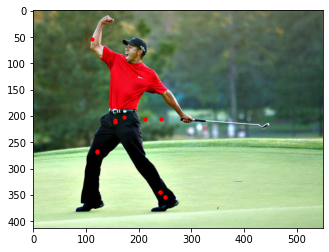

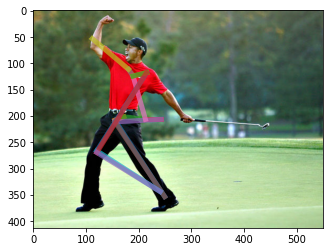

In [40]:
image_SHN, keypoints_SHN = predict(model_SHN, test_image)
draw_keypoints_on_image(image_SHN, keypoints_SHN)
draw_skeleton_on_image(image_SHN, keypoints_SHN)

In [41]:
model_SBL = Simplebaseline(IMAGE_SHAPE)
model_SBL.load_weights(WEIGHTS_PATH)

ValueError: You are trying to load a weight file containing 472 layers into a model with 3 layers.

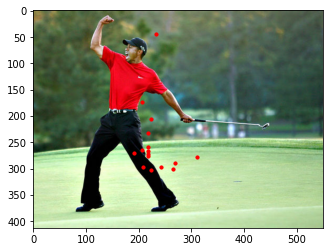

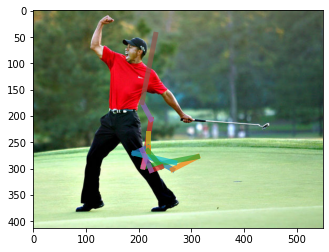

*** SIGSEGV received at time=1690339899 on cpu 3 ***
PC: @     0x7f95c87b0855  (unknown)  nsync::nsync_dll_splice_after_()
    @     0x7f962d2e53c0       1488  (unknown)
    @     0x7f95c87b087b         32  nsync::nsync_dll_make_first_in_list_()
    @     0x7f95c87b08b9         32  nsync::nsync_dll_make_last_in_list_()
    @     0x7f95c87b0ad5         96  nsync::nsync_mu_lock_slow_()
    @     0x7f95c87b0b6d         32  nsync::nsync_mu_lock()
    @     0x7f95bc4a5114         80  TF_NewOperation
    @     0x7f95b5acb198        192  pybind11::cpp_function::initialize<>()::{lambda()#3}::_FUN()
    @     0x7f95b5ac1cf0        544  pybind11::cpp_function::dispatcher()


In [42]:
image_SBL, keypoints_SBL = predict(model_SBL, test_image)
draw_keypoints_on_image(image_SBL, keypoints_SBL)
draw_skeleton_on_image(image_SBL, keypoints_SBL)

# 회고
심플베이스라인에서 뭔가 문제가 발생했다.....  아마 학습안시키고 가중치 가져오려 해서 그런거같다
시간이 부족해서 어쩔수 없는 선택이였지만 매우 아쉽다
이건 내가 조금더 파고들어야 하는 부분이 확실하다